In [1]:
import keras
import os
import librosa


import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\lenovo_pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_labels(path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))    
    return labels, label_indices, to_categorical(label_indices)





In [3]:
from sklearn.model_selection import train_test_split


def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def save_data_to_array(path, max_pad_len):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        melspectrogram_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        #wavfiles = librosa.util.find_files(db)
        #print(wavfiles)
        x=0
        for wavfile in wavfiles:
            name=label+'_'+str(x)
            melspectrogram = wav2melspectrogram(wavfile, name, max_pad_len=max_pad_len)            
            melspectrogram_vectors.append(melspectrogram)            
            x=x+1
        
        #computing PCA and saving
        
        np.save(label + '.npy', melspectrogram_vectors)
        #y=np.load(label + '.npy')
        #y = sklearn.preprocessing.scale(y)
        #y.mean()
        #model = sklearn.decomposition.PCA(n_components=2, whiten=True)
        #model.fit(y)
        #y = model.transform(y)
        #pd.DataFrame(y).to_csv(VALUE_PATH+'/'+label+'.csv')
        
        


def wav2melspectrogram(file_path, name, max_pad_len):
    wave, sr = librosa.load(file_path)
    x = librosa.feature.melspectrogram(wave, sr=sr)
    pad_width = max_pad_len - x.shape[1]
    x = np.pad(x, pad_width=((0, 0), (0, pad_width)), mode='constant')
    x = x.flatten()
    pd.DataFrame(x).to_csv(VALUE_PATH+'/'+name+'.csv')
    return x

In [4]:
DATA_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\Dataset-v2'
VALUE_PATH = r'C:\Users\lenovo_pc\Desktop\CNN_SR\flattened_matrix'


#db = r'C:\Users\lenovo_pc\Desktop\CNN_SR\SampleData'


# Second dimension of the feature is dim2
feature_dim_2 = 22

# Save data to array file first
save_data_to_array(DATA_PATH,feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 128
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 2


y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_sc_train = scaler.transform(X_train)
X_sc_test = scaler.transform(X_test)

NameError: name 'StandardScaler' is not defined

Text(0,0.5,'Cumulative explained variance')

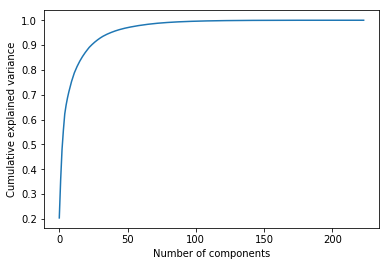

In [6]:
pca = PCA(n_components=500)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [9]:
NCOMPONENTS = 50

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(X_sc_train)
X_pca_test = pca.transform(X_sc_test)
pca_std = np.std(X_pca_train)

print(X_sc_train.shape)
print(X_pca_train.shape)
print(X_pca_test.shape)

(224, 2816)
(224, 50)
(57, 50)


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [33]:
model = Sequential()
layers = 1
units = 128

model.add(Dense(units, input_dim=NCOMPONENTS, activation='relu'))
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(X_pca_train, y_train_hot, epochs=100, batch_size=8, validation_split=0.15, verbose=1)

Train on 190 samples, validate on 34 samples
Epoch 1/100
190/190 [==============================] - 1s 5ms/step - loss: 5.2021 - acc: 0.5421 - val_loss: 0.7253 - val_acc: 0.8529
Epoch 2/100
190/190 [==============================] - 0s 337us/step - loss: 4.7945 - acc: 0.5474 - val_loss: 0.1750 - val_acc: 0.8824
Epoch 3/100
190/190 [==============================] - 0s 358us/step - loss: 4.0007 - acc: 0.5895 - val_loss: 0.3960 - val_acc: 0.9118
Epoch 4/100
190/190 [==============================] - 0s 379us/step - loss: 2.4539 - acc: 0.7105 - val_loss: 0.2348 - val_acc: 0.9706
Epoch 5/100
190/190 [==============================] - 0s 400us/step - loss: 2.8541 - acc: 0.7158 - val_loss: 0.1396 - val_acc: 0.9706
Epoch 6/100
190/190 [==============================] - 0s 400us/step - loss: 2.5235 - acc: 0.7316 - val_loss: 0.1639 - val_acc: 0.9706
Epoch 7/100
190/190 [==============================] - 0s 379us/step - loss: 2.1749 - acc: 0.7632 - val_loss: 0.1020 - val_acc: 0.9706
Epoch 8/100


Epoch 61/100
190/190 [==============================] - 0s 337us/step - loss: 0.3411 - acc: 0.9684 - val_loss: 0.4741 - val_acc: 0.9706
Epoch 62/100
190/190 [==============================] - 0s 358us/step - loss: 0.1341 - acc: 0.9895 - val_loss: 0.4741 - val_acc: 0.9706
Epoch 63/100
190/190 [==============================] - 0s 400us/step - loss: 0.0747 - acc: 0.9842 - val_loss: 0.4741 - val_acc: 0.9706
Epoch 64/100
190/190 [==============================] - 0s 358us/step - loss: 0.1909 - acc: 0.9842 - val_loss: 0.4741 - val_acc: 0.9706
Epoch 65/100
190/190 [==============================] - 0s 358us/step - loss: 0.0564 - acc: 0.9842 - val_loss: 0.4741 - val_acc: 0.9706
Epoch 66/100
190/190 [==============================] - 0s 337us/step - loss: 0.2334 - acc: 0.9789 - val_loss: 0.4741 - val_acc: 0.9706
Epoch 67/100
190/190 [==============================] - 0s 358us/step - loss: 0.1548 - acc: 0.9789 - val_loss: 0.4741 - val_acc: 0.9706
Epoch 68/100
190/190 [==========================

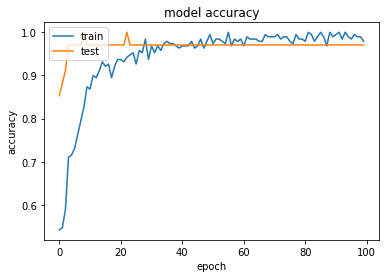

In [34]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


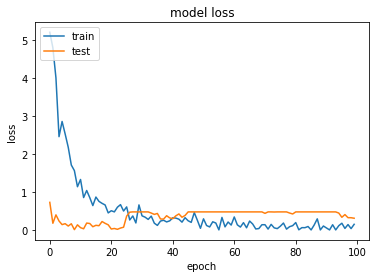

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
score = model.evaluate(X_pca_train, y_train_hot, verbose=2) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_pca_test, y_test_hot, verbose=2) 
print ("model test data score        : ",round(score[1]*100) , "%")


model train data score       :  100.0 %
model test data score        :  98.0 %
